In [1]:
# ========================================
# Library
# ========================================
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
# import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb
import optuna

In [2]:
i_path = '../../train/'
o_path = '../model/'

TARGET = 'is_congestion'

In [3]:
train_df = pd.read_csv(i_path + 'train.csv')
road_df = pd.read_csv(i_path + 'road_local.csv')
search_spec_df = pd.read_csv(i_path + 'search_specified.csv')
search_unspec_df = pd.read_csv(i_path + 'search_unspecified.csv')

In [4]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

In [5]:
def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [6]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [7]:
train.head(5)

,datetime,start_code,end_code,KP,OCC,allCars,speed,is_congestion,year,month,day,hour,search_specified,date,search_unspecified,road_code,direction,limit_speed,start_KP,end_KP,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,dayofweek
0,2021-04-08 00:00:00,1110210,1800006,2.48,1.833333,507,94.208661,0,2021,4,8,0,15.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
1,2021-04-08 01:00:00,1110210,1800006,2.48,1.750000,444,94.469663,0,2021,4,8,1,6.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
2,2021-04-08 02:00:00,1110210,1800006,2.48,1.500000,363,92.593407,0,2021,4,8,2,3.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
3,2021-04-08 03:00:00,1110210,1800006,2.48,1.583333,430,94.501160,0,2021,4,8,3,26.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
4,2021-04-08 04:00:00,1110210,1800006,2.48,1.750000,500,94.079840,0,2021,4,8,4,30.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3


In [8]:
train['section'] = train['start_code'].astype(str) + '_' + train['KP'].astype(str) + '_' + train['end_code'].astype(str)

In [9]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'hour', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_specified', 'search_unspecified', 'KP', 'start_KP', 'end_KP', 'limit_speed', 'OCC']
feature_cols = cat_cols + num_cols

In [10]:
train[feature_cols].head(5)

,road_code,start_code,end_code,section,direction,hour,dayofweek,year,month,day,hour,search_specified,search_unspecified,KP,start_KP,end_KP,limit_speed,OCC
0,1800,1110210,1800006,1110210_2.48_1800006,下り,0,3,2021,4,8,0,15.0,3419.0,2.48,0.8,9.4,100.0,1.833333
1,1800,1110210,1800006,1110210_2.48_1800006,下り,1,3,2021,4,8,1,6.0,3419.0,2.48,0.8,9.4,100.0,1.750000
2,1800,1110210,1800006,1110210_2.48_1800006,下り,2,3,2021,4,8,2,3.0,3419.0,2.48,0.8,9.4,100.0,1.500000
3,1800,1110210,1800006,1110210_2.48_1800006,下り,3,3,2021,4,8,3,26.0,3419.0,2.48,0.8,9.4,100.0,1.583333
4,1800,1110210,1800006,1110210_2.48_1800006,下り,4,3,2021,4,8,4,30.0,3419.0,2.48,0.8,9.4,100.0,1.750000


In [11]:
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    le_dict[c] = le

100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


In [12]:
def train_lgbm(X, y, cv, model_path=[], params={}, verbose=100):

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records), dtype=np.float32)

    def objective(trial):
        lgb_params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "rf",
            "verbosity": -1,
            "boost_from_average": "false",
            "random_seed": 42,
            "feature_pre_filter": False,
            "max_depth": trial.suggest_int('max_depth', 4, 8),
            "num_leaves": trial.suggest_int("num_leaves", 2, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
            "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
        }

        model = lgb.LGBMClassifier(**lgb_params)

        model.fit(x_train, y_train,
                  eval_set=[(x_valid, y_valid)],
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=50, verbose=True),
                      lgb.log_evaluation(100)
                  ]
                  )

        pred_y = model.predict_proba(x_valid)[:, 1]
        auc = roc_auc_score(y_valid, pred_y)

        return auc

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=10)

        best_params = study.best_params
        clf = lgb.LGBMClassifier(**best_params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=True),
                    lgb.log_evaluation(100)
                ]
                )

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models

In [13]:
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

X = train[feature_cols].values
y = train[TARGET].values

print('train shape:', train.shape)

# training
score, oof_pred, models = train_lgbm(X, y=y, cv=cv_list)

train shape: (5800080, 30)


[I 2024-03-02 13:29:25,812] A new study created in memory with name: no-name-57aeb17c-ee9d-4ac9-a9d7-aa4454708c09


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:29,695] Trial 0 finished with value: 0.9843839490418749 and parameters: {'max_depth': 5, 'num_leaves': 55, 'learning_rate': 0.038281799575419696, 'feature_fraction': 0.8936979297770343, 'bagging_fraction': 0.3671156528976718, 'min_child_samples': 11, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9843839490418749.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.128794
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:33,546] Trial 1 finished with value: 0.9844067478832665 and parameters: {'max_depth': 5, 'num_leaves': 66, 'learning_rate': 0.04269133881847913, 'feature_fraction': 0.8608043816699466, 'bagging_fraction': 0.5500269444384357, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.9844067478832665.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.128786
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:36,507] Trial 2 finished with value: 0.9811435144488119 and parameters: {'max_depth': 4, 'num_leaves': 35, 'learning_rate': 0.006751142664746224, 'feature_fraction': 0.2745915968105211, 'bagging_fraction': 0.8060466646460668, 'min_child_samples': 1, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.9844067478832665.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128882
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:40,042] Trial 3 finished with value: 0.9811499090045899 and parameters: {'max_depth': 4, 'num_leaves': 59, 'learning_rate': 0.06147906497876472, 'feature_fraction': 0.8220987110519609, 'bagging_fraction': 0.9519389994529537, 'min_child_samples': 17, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9844067478832665.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.128831
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:43,752] Trial 4 finished with value: 0.9745010834850634 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.034705951594600624, 'feature_fraction': 0.8563473286167198, 'bagging_fraction': 0.8213925366927554, 'min_child_samples': 24, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9844067478832665.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.128758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130413


[I 2024-03-02 13:29:48,029] Trial 5 finished with value: 0.9912445678822996 and parameters: {'max_depth': 6, 'num_leaves': 88, 'learning_rate': 0.007647756123513874, 'feature_fraction': 0.4235706234537629, 'bagging_fraction': 0.8809783932553711, 'min_child_samples': 21, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9912445678822996.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130505


[I 2024-03-02 13:29:51,962] Trial 6 finished with value: 0.987402217404125 and parameters: {'max_depth': 5, 'num_leaves': 42, 'learning_rate': 0.06098212053697347, 'feature_fraction': 0.3649080817646527, 'bagging_fraction': 0.16472570570554387, 'min_child_samples': 10, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9912445678822996.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:29:55,603] Trial 7 finished with value: 0.9745009929617222 and parameters: {'max_depth': 8, 'num_leaves': 35, 'learning_rate': 0.09957397873137624, 'feature_fraction': 0.7784838091478502, 'bagging_fraction': 0.9064569814121499, 'min_child_samples': 20, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9912445678822996.


Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.128756
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130385


[I 2024-03-02 13:29:59,478] Trial 8 finished with value: 0.9760628193343982 and parameters: {'max_depth': 8, 'num_leaves': 57, 'learning_rate': 0.0870607824193525, 'feature_fraction': 0.36194264941865145, 'bagging_fraction': 0.14264835676804674, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9912445678822996.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.128772


[I 2024-03-02 13:30:03,080] Trial 9 finished with value: 0.9744973001962294 and parameters: {'max_depth': 6, 'num_leaves': 29, 'learning_rate': 0.062028476492706444, 'feature_fraction': 0.8364255370504314, 'bagging_fraction': 0.4928391793266329, 'min_child_samples': 10, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9912445678822996.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.4235706234537629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4235706234537629
[LightGBM] [Warning] bagging_fraction is set=0.8809783932553711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8809783932553711
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.4235706234537629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4235706234537629
[LightGBM] [Warning] bagging_fraction is set=0.8809783932553711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8809783932553711
[LightGBM] [Info] Number of positive: 16784, number of negative: 4623280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

[I 2024-03-02 13:30:13,870] A new study created in memory with name: no-name-c809dfa7-4f8b-4c44-8f41-82432c71bfec


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.129578


[I 2024-03-02 13:30:17,641] Trial 0 finished with value: 0.9866673839862788 and parameters: {'max_depth': 6, 'num_leaves': 74, 'learning_rate': 0.0380957045287632, 'feature_fraction': 0.18848592631218722, 'bagging_fraction': 0.7158690499275012, 'min_child_samples': 21, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9866673839862788.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:20,680] Trial 1 finished with value: 0.9731083039914368 and parameters: {'max_depth': 6, 'num_leaves': 17, 'learning_rate': 0.030645060167782442, 'feature_fraction': 0.24577290438975175, 'bagging_fraction': 0.46106134172726887, 'min_child_samples': 7, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128814
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:24,036] Trial 2 finished with value: 0.9731018357685973 and parameters: {'max_depth': 4, 'num_leaves': 13, 'learning_rate': 0.05963074823692674, 'feature_fraction': 0.695347667057199, 'bagging_fraction': 0.41245041211164657, 'min_child_samples': 7, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.128828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130423


[I 2024-03-02 13:30:28,424] Trial 3 finished with value: 0.9832966954946339 and parameters: {'max_depth': 5, 'num_leaves': 65, 'learning_rate': 0.09432086834246274, 'feature_fraction': 0.4535841211646603, 'bagging_fraction': 0.619538903118833, 'min_child_samples': 2, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9866673839862788.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:32,125] Trial 4 finished with value: 0.9793748358340616 and parameters: {'max_depth': 4, 'num_leaves': 51, 'learning_rate': 0.04679088642213748, 'feature_fraction': 0.7608780504412871, 'bagging_fraction': 0.7960637196991086, 'min_child_samples': 12, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.128812
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:36,188] Trial 5 finished with value: 0.9849624927491479 and parameters: {'max_depth': 6, 'num_leaves': 99, 'learning_rate': 0.09201818262207385, 'feature_fraction': 0.2807405853469958, 'bagging_fraction': 0.7405103972758534, 'min_child_samples': 20, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128769
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:39,238] Trial 6 finished with value: 0.9731099499207698 and parameters: {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.09372304217953611, 'feature_fraction': 0.9709365551719136, 'bagging_fraction': 0.7423757484433543, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.128788
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:42,422] Trial 7 finished with value: 0.9673546308088972 and parameters: {'max_depth': 5, 'num_leaves': 11, 'learning_rate': 0.05805421280147264, 'feature_fraction': 0.7491526039306001, 'bagging_fraction': 0.2107562508937036, 'min_child_samples': 24, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.128847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130422


[I 2024-03-02 13:30:46,382] Trial 8 finished with value: 0.9722029302325532 and parameters: {'max_depth': 7, 'num_leaves': 15, 'learning_rate': 0.09616584548573136, 'feature_fraction': 0.41765301061764665, 'bagging_fraction': 0.5066590374334015, 'min_child_samples': 22, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9866673839862788.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:30:49,864] Trial 9 finished with value: 0.9814636189707956 and parameters: {'max_depth': 7, 'num_leaves': 56, 'learning_rate': 0.09886803361426946, 'feature_fraction': 0.16731097072221782, 'bagging_fraction': 0.9461463777834093, 'min_child_samples': 2, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9866673839862788.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.129569
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.18848592631218722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18848592631218722
[LightGBM] [Warning] bagging_fraction is set=0.7158690499275012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158690499275012
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.18848592631218722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18848592631218722
[LightGBM] [Warning] bagging_fraction is set=0.7158690499275012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158690499275012
[LightGBM] [Info] Number of positive: 16693, number of negative: 4623371
[LightG

[I 2024-03-02 13:30:58,433] A new study created in memory with name: no-name-59d66991-1da1-444b-a7f5-a6ec62014cc7


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:02,459] Trial 0 finished with value: 0.9890687307616547 and parameters: {'max_depth': 8, 'num_leaves': 49, 'learning_rate': 0.05516290737656855, 'feature_fraction': 0.2188378960238453, 'bagging_fraction': 0.45396807731191063, 'min_child_samples': 21, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9890687307616547.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128543
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.129373


[I 2024-03-02 13:31:08,413] Trial 1 finished with value: 0.9914563188646611 and parameters: {'max_depth': 7, 'num_leaves': 79, 'learning_rate': 0.0046826644367737764, 'feature_fraction': 0.6043731970575541, 'bagging_fraction': 0.10567688051410684, 'min_child_samples': 22, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9914563188646611.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:12,092] Trial 2 finished with value: 0.9864537749632747 and parameters: {'max_depth': 7, 'num_leaves': 17, 'learning_rate': 0.03503519896928922, 'feature_fraction': 0.9606848754922305, 'bagging_fraction': 0.34298701956550864, 'min_child_samples': 1, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.9914563188646611.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.128616
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:15,382] Trial 3 finished with value: 0.9890380966788174 and parameters: {'max_depth': 4, 'num_leaves': 83, 'learning_rate': 0.05107157948920505, 'feature_fraction': 0.29710847779809835, 'bagging_fraction': 0.30660334980828163, 'min_child_samples': 3, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.9914563188646611.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.129623


[I 2024-03-02 13:31:19,684] Trial 4 finished with value: 0.9903371861946444 and parameters: {'max_depth': 4, 'num_leaves': 81, 'learning_rate': 0.061332389069287827, 'feature_fraction': 0.5327300204633743, 'bagging_fraction': 0.9021649989096167, 'min_child_samples': 22, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9914563188646611.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.1286


[I 2024-03-02 13:31:23,006] Trial 5 finished with value: 0.9864657955020996 and parameters: {'max_depth': 7, 'num_leaves': 27, 'learning_rate': 0.07124724801009434, 'feature_fraction': 0.21632803626890118, 'bagging_fraction': 0.6816721589738806, 'min_child_samples': 11, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.9914563188646611.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:26,768] Trial 6 finished with value: 0.986463714108013 and parameters: {'max_depth': 5, 'num_leaves': 22, 'learning_rate': 0.00797453772418078, 'feature_fraction': 0.6538772145771689, 'bagging_fraction': 0.3993902863445802, 'min_child_samples': 3, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.9914563188646611.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.128585
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:30,193] Trial 7 finished with value: 0.9864532133205828 and parameters: {'max_depth': 6, 'num_leaves': 22, 'learning_rate': 0.028117822601024908, 'feature_fraction': 0.8609847285839354, 'bagging_fraction': 0.8405047218274575, 'min_child_samples': 16, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9914563188646611.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128595
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:33,812] Trial 8 finished with value: 0.9890639463047021 and parameters: {'max_depth': 7, 'num_leaves': 54, 'learning_rate': 0.0802665989622966, 'feature_fraction': 0.282845368964862, 'bagging_fraction': 0.7046464873038464, 'min_child_samples': 7, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9914563188646611.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.12857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130378


[I 2024-03-02 13:31:37,722] Trial 9 finished with value: 0.9910107421745751 and parameters: {'max_depth': 4, 'num_leaves': 26, 'learning_rate': 0.0897556194048552, 'feature_fraction': 0.44616656917014264, 'bagging_fraction': 0.19714465713334647, 'min_child_samples': 4, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.9914563188646611.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6043731970575541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043731970575541
[LightGBM] [Warning] bagging_fraction is set=0.10567688051410684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10567688051410684
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6043731970575541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043731970575541
[LightGBM] [Warning] bagging_fraction is set=0.10567688051410684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10567688051410684
[LightGBM] [Info] Number of positive: 16642, number of negative: 4623422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[I 2024-03-02 13:31:47,668] A new study created in memory with name: no-name-71c1e8de-546f-4893-99e2-44cfbaab2f3e


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:31:51,145] Trial 0 finished with value: 0.9773453235557632 and parameters: {'max_depth': 4, 'num_leaves': 50, 'learning_rate': 0.04985105756369451, 'feature_fraction': 0.269337610685261, 'bagging_fraction': 0.6877096195523529, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9773453235557632.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130507


[I 2024-03-02 13:31:55,702] Trial 1 finished with value: 0.9817819681192964 and parameters: {'max_depth': 6, 'num_leaves': 50, 'learning_rate': 0.04138836928221688, 'feature_fraction': 0.5165091042968694, 'bagging_fraction': 0.16158654102640477, 'min_child_samples': 7, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.9817819681192964.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.129796


[I 2024-03-02 13:31:59,172] Trial 2 finished with value: 0.9838456890912708 and parameters: {'max_depth': 5, 'num_leaves': 52, 'learning_rate': 0.07610418230239607, 'feature_fraction': 0.1935568124758435, 'bagging_fraction': 0.4497871571250058, 'min_child_samples': 8, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.9838456890912708.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:32:02,940] Trial 3 finished with value: 0.9773591947332216 and parameters: {'max_depth': 4, 'num_leaves': 19, 'learning_rate': 0.07337114050172129, 'feature_fraction': 0.6723737711038295, 'bagging_fraction': 0.5238872991521509, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.9838456890912708.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.128939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.129735


[I 2024-03-02 13:32:08,350] Trial 4 finished with value: 0.9708038260427881 and parameters: {'max_depth': 7, 'num_leaves': 38, 'learning_rate': 0.0764481739132056, 'feature_fraction': 0.6264105773348746, 'bagging_fraction': 0.6671185563716396, 'min_child_samples': 18, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.9838456890912708.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:32:13,606] Trial 5 finished with value: 0.9816521085077613 and parameters: {'max_depth': 5, 'num_leaves': 79, 'learning_rate': 0.07343440940398009, 'feature_fraction': 0.7230889895160808, 'bagging_fraction': 0.12778300508907833, 'min_child_samples': 6, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.9838456890912708.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128861
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:32:17,643] Trial 6 finished with value: 0.9816522855753894 and parameters: {'max_depth': 5, 'num_leaves': 88, 'learning_rate': 0.026328498564705906, 'feature_fraction': 0.7675785036203422, 'bagging_fraction': 0.4919797197706488, 'min_child_samples': 18, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.9838456890912708.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.12886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.128756


[I 2024-03-02 13:32:22,279] Trial 7 finished with value: 0.9816835664400398 and parameters: {'max_depth': 7, 'num_leaves': 87, 'learning_rate': 0.024227345217877984, 'feature_fraction': 0.8070355098956508, 'bagging_fraction': 0.44338803370209684, 'min_child_samples': 14, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.9838456890912708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.128949


[I 2024-03-02 13:32:27,055] Trial 8 finished with value: 0.9773501614413591 and parameters: {'max_depth': 4, 'num_leaves': 55, 'learning_rate': 0.030573793360965728, 'feature_fraction': 0.9557266586629205, 'bagging_fraction': 0.8940818979636427, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.9838456890912708.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:32:31,060] Trial 9 finished with value: 0.9719613059594888 and parameters: {'max_depth': 8, 'num_leaves': 70, 'learning_rate': 0.07255930460012743, 'feature_fraction': 0.7921199882135589, 'bagging_fraction': 0.7407016688397049, 'min_child_samples': 10, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.9838456890912708.


Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.128789
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.1935568124758435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1935568124758435
[LightGBM] [Warning] bagging_fraction is set=0.4497871571250058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4497871571250058
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.1935568124758435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1935568124758435
[LightGBM] [Warning] bagging_fraction is set=0.4497871571250058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4497871571250058
[LightGBM] [Info] Number of positive: 16503, number of negative: 4623561
[LightGBM] [I

[I 2024-03-02 13:32:39,043] A new study created in memory with name: no-name-2c5bc6e5-1620-465b-9b90-9912d5b36073


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:32:42,763] Trial 0 finished with value: 0.9727369534223714 and parameters: {'max_depth': 8, 'num_leaves': 49, 'learning_rate': 0.09339357259834351, 'feature_fraction': 0.8559793414524831, 'bagging_fraction': 0.38838812976343823, 'min_child_samples': 6, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9727369534223714.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.128829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.12987


[I 2024-03-02 13:32:47,966] Trial 1 finished with value: 0.9686612600035013 and parameters: {'max_depth': 6, 'num_leaves': 10, 'learning_rate': 0.02208999753571919, 'feature_fraction': 0.6071577917981783, 'bagging_fraction': 0.21771269080313388, 'min_child_samples': 4, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9727369534223714.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130622


[I 2024-03-02 13:32:52,175] Trial 2 finished with value: 0.9821452715531995 and parameters: {'max_depth': 4, 'num_leaves': 90, 'learning_rate': 0.012121895818684007, 'feature_fraction': 0.47737968994796875, 'bagging_fraction': 0.6936671962052979, 'min_child_samples': 4, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.9821452715531995.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130444


[I 2024-03-02 13:32:56,163] Trial 3 finished with value: 0.9744936238923972 and parameters: {'max_depth': 7, 'num_leaves': 46, 'learning_rate': 0.04686526796281906, 'feature_fraction': 0.4302392745593947, 'bagging_fraction': 0.1457040955855891, 'min_child_samples': 15, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.9821452715531995.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130522


[I 2024-03-02 13:33:00,015] Trial 4 finished with value: 0.9702839258035596 and parameters: {'max_depth': 7, 'num_leaves': 17, 'learning_rate': 0.018771693006930514, 'feature_fraction': 0.480516457661311, 'bagging_fraction': 0.9764792968304202, 'min_child_samples': 16, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.9821452715531995.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.130385


[I 2024-03-02 13:33:04,610] Trial 5 finished with value: 0.9859649490486478 and parameters: {'max_depth': 7, 'num_leaves': 81, 'learning_rate': 0.09273071854212228, 'feature_fraction': 0.5260249987154931, 'bagging_fraction': 0.5765759248376267, 'min_child_samples': 10, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9859649490486478.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:33:08,940] Trial 6 finished with value: 0.9837345153954911 and parameters: {'max_depth': 7, 'num_leaves': 98, 'learning_rate': 0.09710143485903121, 'feature_fraction': 0.7419769174258126, 'bagging_fraction': 0.6121256262622872, 'min_child_samples': 13, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9859649490486478.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.12878
Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:33:12,452] Trial 7 finished with value: 0.981846991658502 and parameters: {'max_depth': 4, 'num_leaves': 37, 'learning_rate': 0.01698795861190784, 'feature_fraction': 0.24534841070938967, 'bagging_fraction': 0.4809376482534323, 'min_child_samples': 23, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9859649490486478.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.13019


[I 2024-03-02 13:33:16,677] Trial 8 finished with value: 0.9574394686124637 and parameters: {'max_depth': 4, 'num_leaves': 3, 'learning_rate': 0.03608783098378408, 'feature_fraction': 0.6074114286863295, 'bagging_fraction': 0.47593789414673926, 'min_child_samples': 6, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9859649490486478.


Training until validation scores don't improve for 50 rounds


[I 2024-03-02 13:33:19,826] Trial 9 finished with value: 0.981846991658502 and parameters: {'max_depth': 4, 'num_leaves': 26, 'learning_rate': 0.09037557097375863, 'feature_fraction': 0.24921059058876588, 'bagging_fraction': 0.6817829237268346, 'min_child_samples': 11, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9859649490486478.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.128966
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5260249987154931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260249987154931
[LightGBM] [Warning] bagging_fraction is set=0.5765759248376267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5765759248376267
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5260249987154931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260249987154931
[LightGBM] [Warning] bagging_fraction is set=0.5765759248376267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5765759248376267
[LightGBM] [Info] Number of positive: 16434, number of negative: 4623630
[LightGBM] 

In [14]:
# 最適な閾値を探索

def func(x_list, df, oof):
    score = f1_score(df[TARGET], oof>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  args=(train, oof_pred), method="nelder-mead")
threshold = result.x[0]
train['pred'] = (oof_pred>threshold).astype(int)
print('threshold:', threshold)
print(classification_report(train[TARGET], train['pred']))

threshold: 0.1478515624999997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5779316
           1       0.82      0.88      0.85     20764

    accuracy                           1.00   5800080
   macro avg       0.91      0.94      0.92   5800080
weighted avg       1.00      1.00      1.00   5800080



In [19]:
with open('../model/model.pickle', mode='wb') as f:
    pickle.dump(models,f,protocol=2)

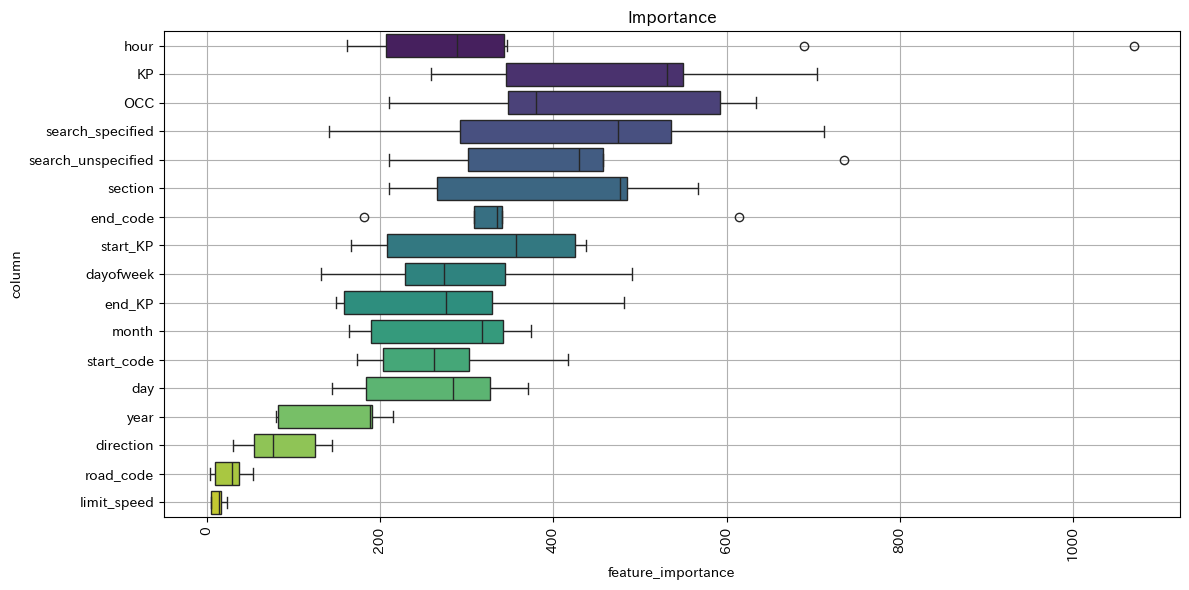

In [20]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

In [21]:
models

[LGBMClassifier(bagging_fraction=0.8809783932553711,
                feature_fraction=0.4235706234537629,
                learning_rate=0.007647756123513874, max_depth=6,
                min_child_samples=21, min_data_in_leaf=4, num_leaves=88),
 LGBMClassifier(bagging_fraction=0.7158690499275012,
                feature_fraction=0.18848592631218722,
                learning_rate=0.0380957045287632, max_depth=6,
                min_child_samples=21, min_data_in_leaf=4, num_leaves=74),
 LGBMClassifier(bagging_fraction=0.10567688051410684,
                feature_fraction=0.6043731970575541,
                learning_rate=0.0046826644367737764, max_depth=7,
                min_child_samples=22, min_data_in_leaf=1, num_leaves=79),
 LGBMClassifier(bagging_fraction=0.4497871571250058,
                feature_fraction=0.1935568124758435,
                learning_rate=0.07610418230239607, max_depth=5,
                min_child_samples=8, min_data_in_leaf=4, num_leaves=52),
 LGBMClassifier(baggi